# Classification with KerasCV

In [1]:
import os

# os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np

import keras
from keras import losses
# from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics

import keras_cv

# Import tensorflow for [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds

2024-01-24 13:34:52.533238: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 13:34:54.623528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


### Inference with a pretrained classifier

In [2]:
classifier = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet_classifier"
)

2024-01-24 13:35:03.602128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-24 13:35:03.777343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-24 13:35:03.777410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-24 13:35:03.780000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-24 13:35:03.780108: I tensorflow/compile

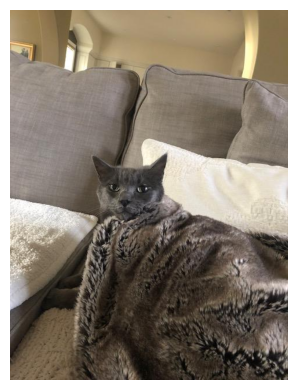

In [14]:
filepath = keras.utils.get_file(origin="https://i.imgur.com/9i63gLN.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)
keras_cv.visualization.plot_image_gallery(
    np.array([image]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4
)

In [4]:
predictions = classifier.predict(np.expand_dims(image, axis=0))

2024-01-24 12:47:44.718864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-24 12:47:45.126545: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 5s 5s/step


In [12]:
top_classes = predictions[0].argsort(axis=-1)
print(top_classes)

[448 988 491 924 455 127 928 124 935 956 485 870 931 316  90 561 740 398
 927 781 982 397 939 381 695  84  37 607 571 724 573 426 923 522 801 943
 536  11 540 843 932 521  30 319 983  89 621  55 758 746 458 555 113 903
 783  18 123 926 953 989 518 986 640  31 963 645 447 696 886 230  50 938
 125 156 805 767 544 786 139  87 809 122 628 864 535 136 128 967 959 374
 849 188 143 346 866 510 413 247 960  17 560 688 941 703  28  96 955 872
 513 517 754 723 586 951 835 922 642 771 471 890 929 788 937 952 643  10
 957 408 950 590 531 933 798 107 595 800  48 992 241 665 167  35 819  95
  14 759 403 409 920  91 710 304 934 684 121 856 716 482  33   0 641 685
 766 848 635 877 509 166 768 822 365 752 481 407 563 745 990 949 751 217
 915 844 494  74 382  15 430 760 875 449 575 569 791 375 440 871 737 307
 944 130 981   8 998 611 738 429  85 826 406 238 832  88 773 415 327 763
 258  13  36   1 829 916 859 215 108  70 874 105 218 119 146 432 530 444
  69 779  56 558 787 300  57 152 100 547 401 305 83

In [10]:
classes = keras.utils.get_file(
    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"
)
with open(classes, "rb") as f:
    classes = json.load(f)

33567/33567 [==============================] - 0s 1us/step


In [15]:
top_five = [classes[str(i)] for i in top_classes[-5:]]
print("top five classes are:", top_five)

top five classes are: ['lynx, catamount', 'tabby, tabby cat', 'quilt, comforter, comfort, puff', 'Egyptian cat', 'velvet']


### Fine tuning a pretrained classifier

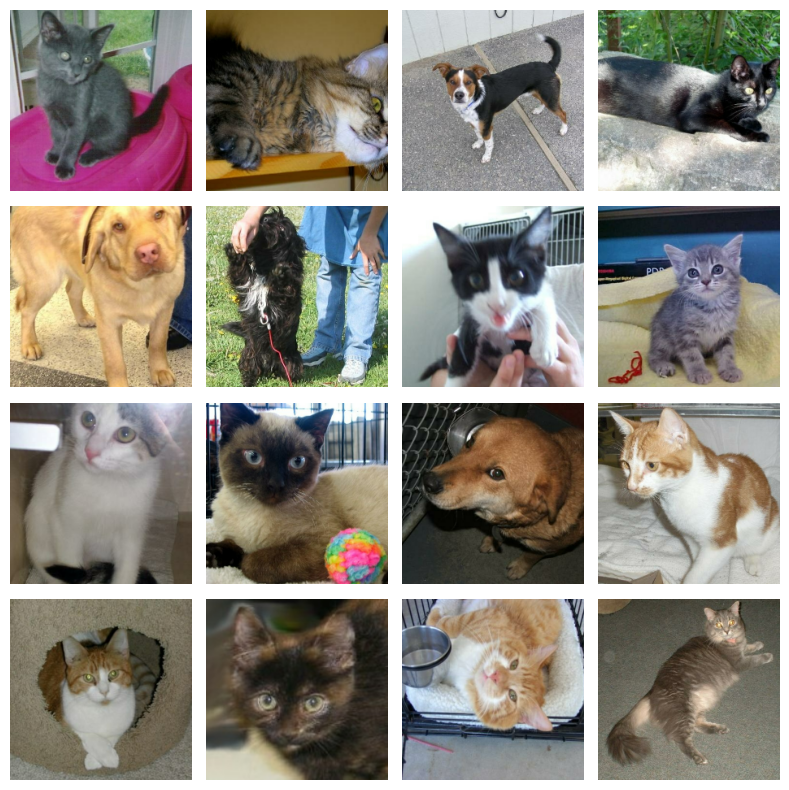

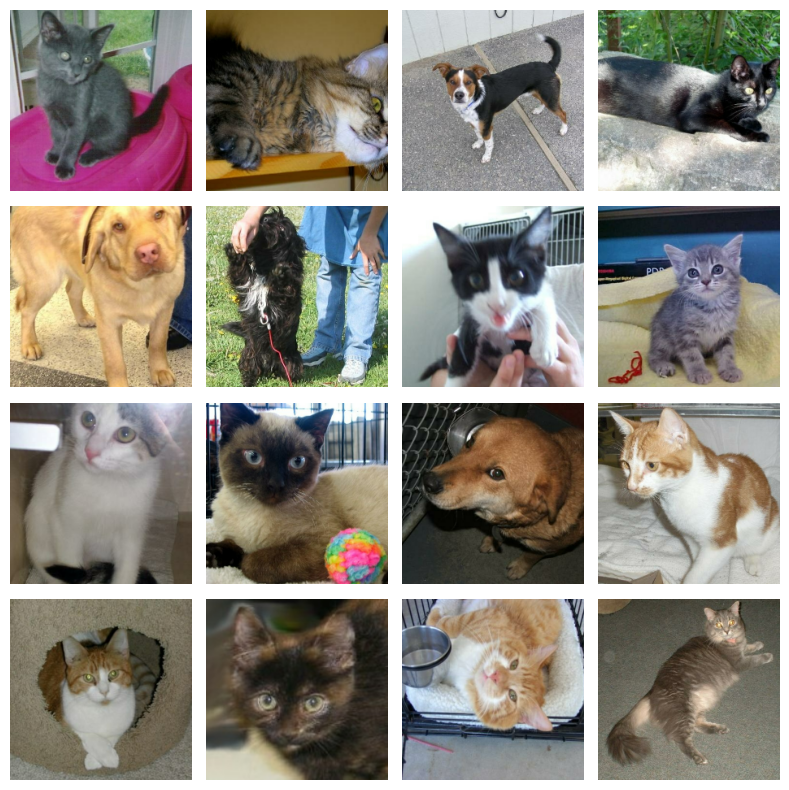

In [10]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

data, dataset_info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

num_classes = dataset_info.features["label"].num_classes

resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32)
    # Staticly resize images as we only iterate the dataset once.
    return resizing(image), tf.one_hot(label, num_classes)


# Shuffle the dataset to increase diversity of batches.
# 10*BATCH_SIZE follows the assumption that bigger machines can handle bigger
# shuffle buffers.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(1)

images = next(iter(train_dataset.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

In [3]:
model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=2
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

In [12]:
model.fit(train_dataset)
# model.fit(train_dataset,
#                     epochs=6)

1454/1454 [==============================] - 1057s 727ms/step - loss: 0.1466 - accuracy: 0.9528


In [15]:
predictions = model.predict(np.expand_dims(image, axis=0))

classes = {0: "cat", 1: "dog"}
print("Top class is:", classes[predictions[0].argmax()])

2024-01-24 14:25:42.588407: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 522.32MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-24 14:25:43.034176: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 438.44MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 7s 7s/step
Top class is: cat


In [16]:
print(predictions)

[[0.96790624 0.03209383]]


### Train a Classifier from Scratch

In [31]:
NUM_CLASSES = 101
# Change epochs to 100~ to fully train.
EPOCHS = 6
BATCH_SIZE = 16

def package_inputs(image, label):
    return {"images": image, "labels": tf.one_hot(label, NUM_CLASSES)}


train_ds, eval_ds = tfds.load(
    "caltech101", split=["train", "test"], as_supervised="true"
)
# , num_parallel_calls=tf.data.AUTOTUNE
train_ds = train_ds.map(package_inputs).prefetch(1)
eval_ds = eval_ds.map(package_inputs).prefetch(1)

train_ds = train_ds.shuffle(BATCH_SIZE * 16)

2024-01-24 15:07:56.123635: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


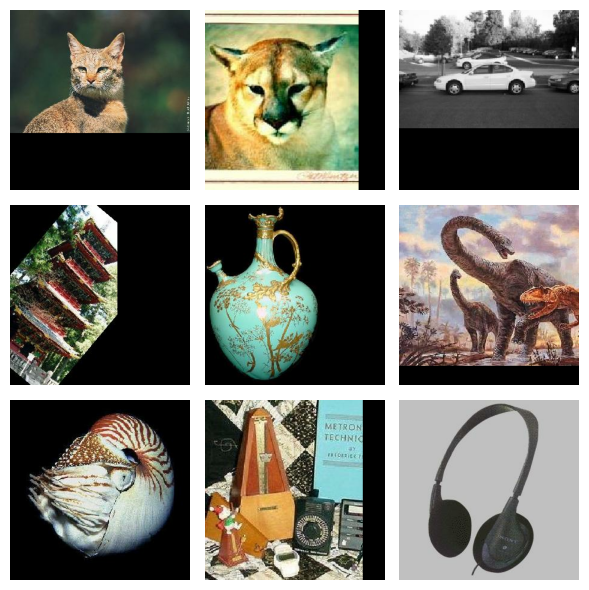

In [32]:
train_ds = train_ds.ragged_batch(BATCH_SIZE)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE)

batch = next(iter(train_ds.take(1)))
image_batch = batch["images"]
label_batch = batch["labels"]

keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

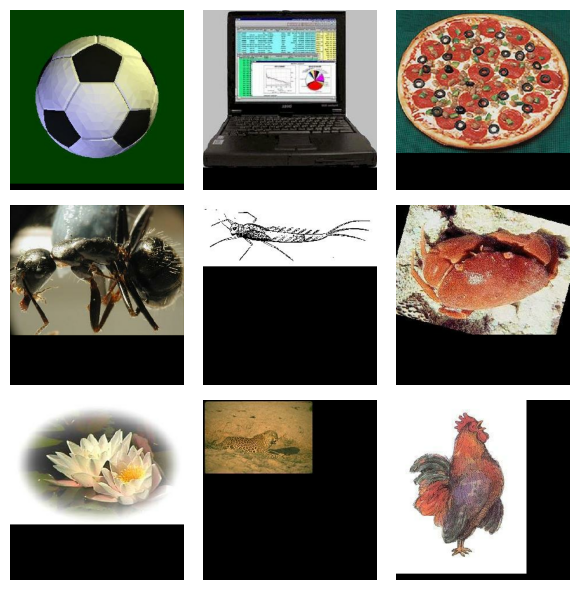

In [21]:
random_flip = keras_cv.layers.RandomFlip()
augmenters = [random_flip]

image_batch = random_flip(image_batch)
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

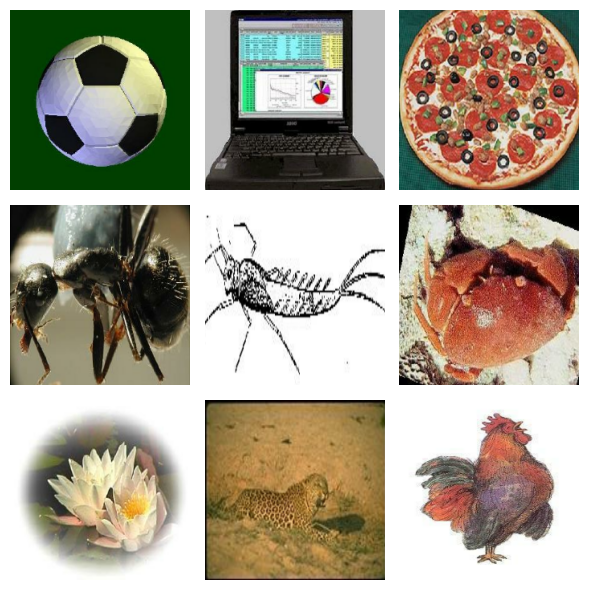

In [22]:
crop_and_resize = keras_cv.layers.RandomCropAndResize(
    target_size=IMAGE_SIZE,
    crop_area_factor=(0.8, 1.0),
    aspect_ratio_factor=(0.9, 1.1),
)
augmenters += [crop_and_resize]

image_batch = crop_and_resize(image_batch)
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

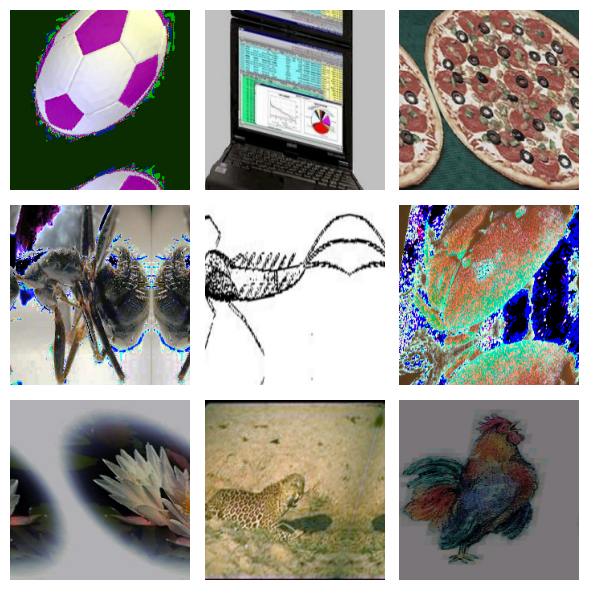

In [23]:
rand_augment = keras_cv.layers.RandAugment(
    augmentations_per_image=3,
    value_range=(0, 255),
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)
augmenters += [rand_augment]

image_batch = rand_augment(image_batch)
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

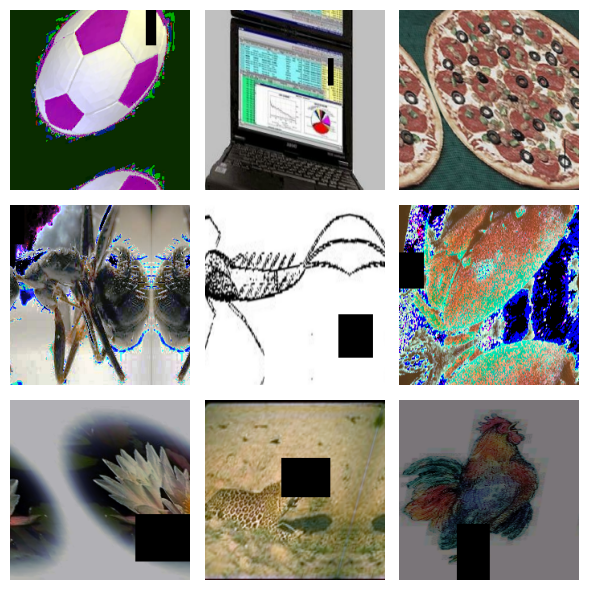

In [24]:
random_cutout = keras_cv.layers.RandomCutout(width_factor=0.4, height_factor=0.4)
keras_cv.visualization.plot_image_gallery(
    random_cutout(image_batch),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

2024-01-24 15:08:19.670833: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1319152083724051089
2024-01-24 15:08:19.670940: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1451047424514490504
2024-01-24 15:08:19.671041: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12531684701510435084
2024-01-24 15:08:19.671108: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4995578140711461910
2024-01-24 15:08:19.671175: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7004055996635915552
2024-01-24 15:08:19.671199: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1532726777067857396
2024-01-24 15:08:19.671214: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv it

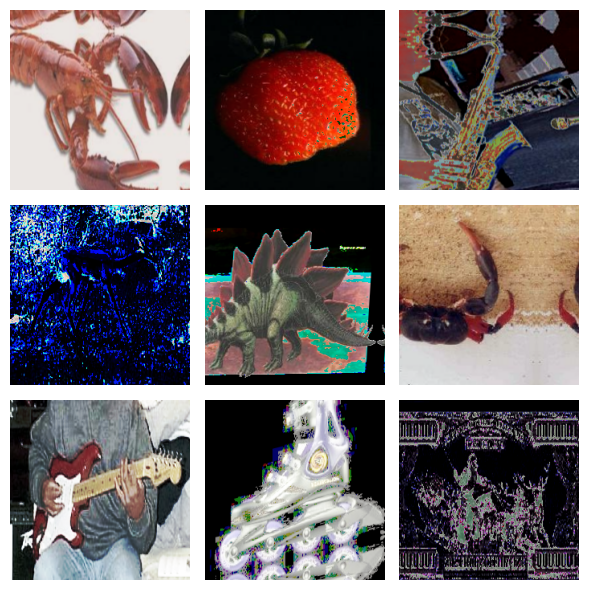

In [33]:
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn).prefetch(1)

image_batch = next(iter(train_ds.take(1)))["images"]
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

2024-01-24 15:08:32.737393: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


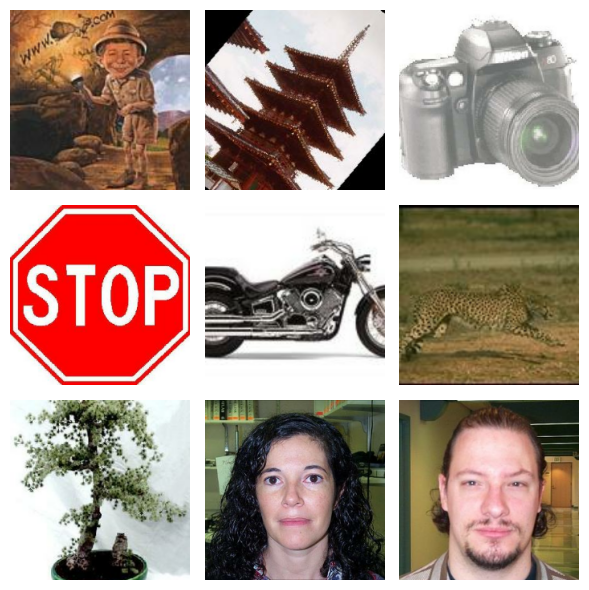

In [34]:
inference_resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing)

image_batch = next(iter(eval_ds.take(1)))["images"]
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [35]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]


train_ds = train_ds.map(unpackage_dict).prefetch(1)
eval_ds = eval_ds.map(unpackage_dict).prefetch(1)

In [28]:
backbone = keras_cv.models.EfficientNetV2B0Backbone()
model = keras.Sequential(
    [
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(101, activation="softmax"),
    ]
)

100%|██████████| 1.77k/1.77k [00:00<00:00, 1.27MB/s]


In [29]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[
        metrics.CategoricalAccuracy(),
        metrics.TopKCategoricalAccuracy(k=5),
    ],
)

In [36]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=eval_ds,
)

Epoch 1/6


2024-01-24 15:09:04.971563: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


192/192 [==============================] - ETA: 0s - loss: 6.5671 - categorical_accuracy: 0.0088 - top_k_categorical_accuracy: 0.0513